---

---

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import math

---

---

Successfully read the 5th frame.


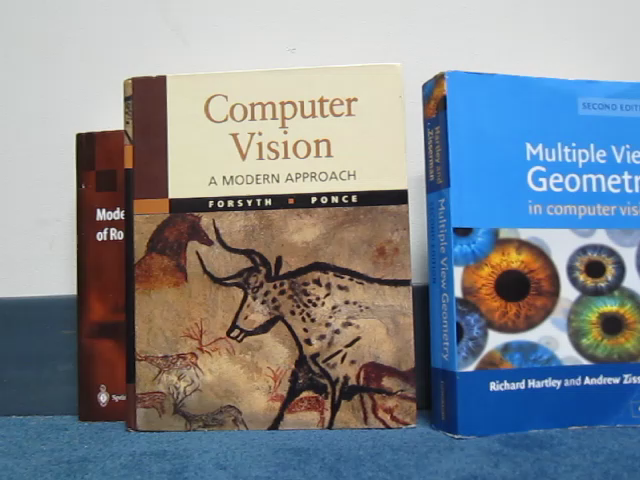

In [5]:
book_img = cv2.imread('/content/drive/MyDrive/assignment_2_materials/cv_cover.jpg', cv2.IMREAD_GRAYSCALE)
cap = cv2.VideoCapture('/content/drive/MyDrive/assignment_2_materials/book.mov')
if not cap.isOpened():
    print("Error: Cannot open video")
else:
    frame_number = 0
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if ret:
        print("Successfully read the 5th frame.")
    else:
        print("Error: Could not read the 5th frame.")
cap.release()
if ret:
    cv2_imshow(frame)


In [6]:
video_frame = frame

In [7]:
def get_features(  frame , book_img = book_img ) :
  sift = cv2.SIFT_create()

  keypoints_book, descriptors_book = sift.detectAndCompute(book_img, None)
  keypoints_frame, descriptors_frame = sift.detectAndCompute(frame, None)

  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
  matches = bf.knnMatch(descriptors_book, descriptors_frame, k=2)
  good_matches = []

  for m, n in matches:
    # equation goes like this -->  bestmatch  / second best match < threshold  --> we are good
      if m.distance < 0.75 * n.distance:
          good_matches.append(m)
  good_matches = sorted(good_matches, key=lambda x: x.distance)[:50]

  src_points = np.float32([keypoints_book[m.queryIdx].pt for m in good_matches])
  dst_points = np.float32([keypoints_frame[m.trainIdx].pt for m in good_matches])
  return src_points , dst_points

In [8]:
sift = cv2.SIFT_create()
keypoints_book, descriptors_book = sift.detectAndCompute(book_img, None)
keypoints_frame, descriptors_frame = sift.detectAndCompute(frame , None)

In [14]:
print(keypoints_book[0].pt) # we can get octave also and dominant orientation

(2.790301561355591, 39.857112884521484)


In [13]:
len(descriptors_book[1])

128

In [21]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches = bf.knnMatch(descriptors_book, descriptors_frame, k=2)
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)
good_matches = sorted(good_matches, key=lambda x: x.distance)[:50]

In [22]:
matches[0][0].distance
#  cv2.match object 3ndo 4wyt props mohma
# queryIdx --> idx of keypoint from query Image (hna da el book image)
# trainIdz --> idx of keypoint from trainImage (el frammmee)
# distance --> distance between them

311.1960754394531

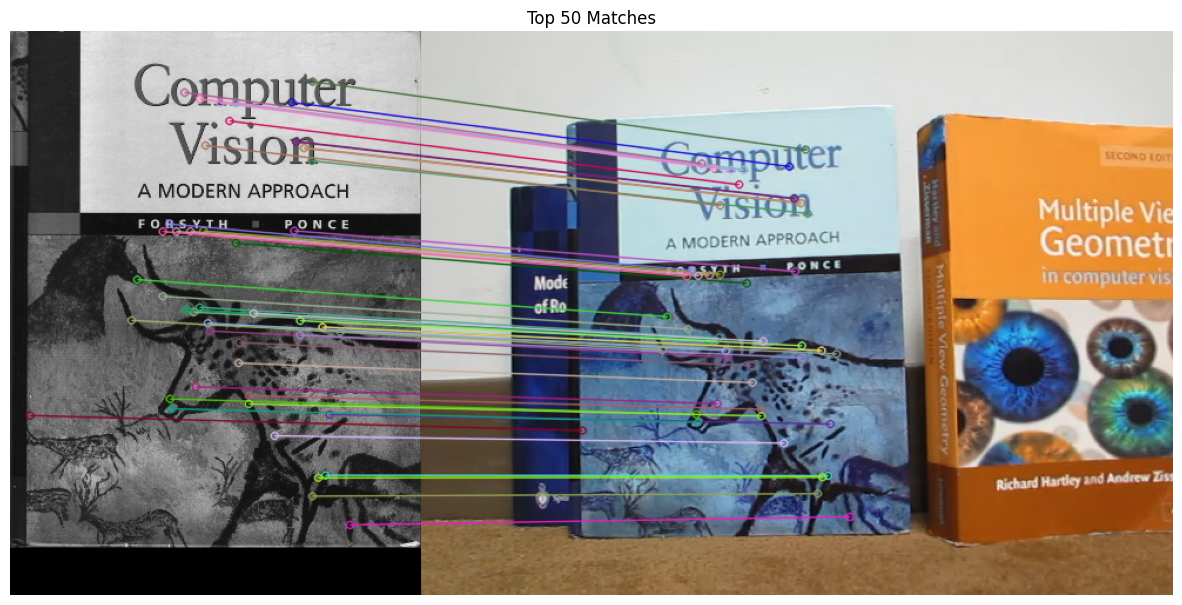

In [ ]:
matched_img = cv2.drawMatches(book_img, keypoints_book, video_frame, keypoints_frame, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(15, 10))
plt.imshow(matched_img, cmap='gray')
plt.title('Top 50 Matches')
plt.axis('off')
plt.show()

In [ ]:
src_points = np.float32([keypoints_book[m.queryIdx].pt for m in good_matches])
dst_points = np.float32([keypoints_frame[m.trainIdx].pt for m in good_matches])

---

---

#dlt METHOD#

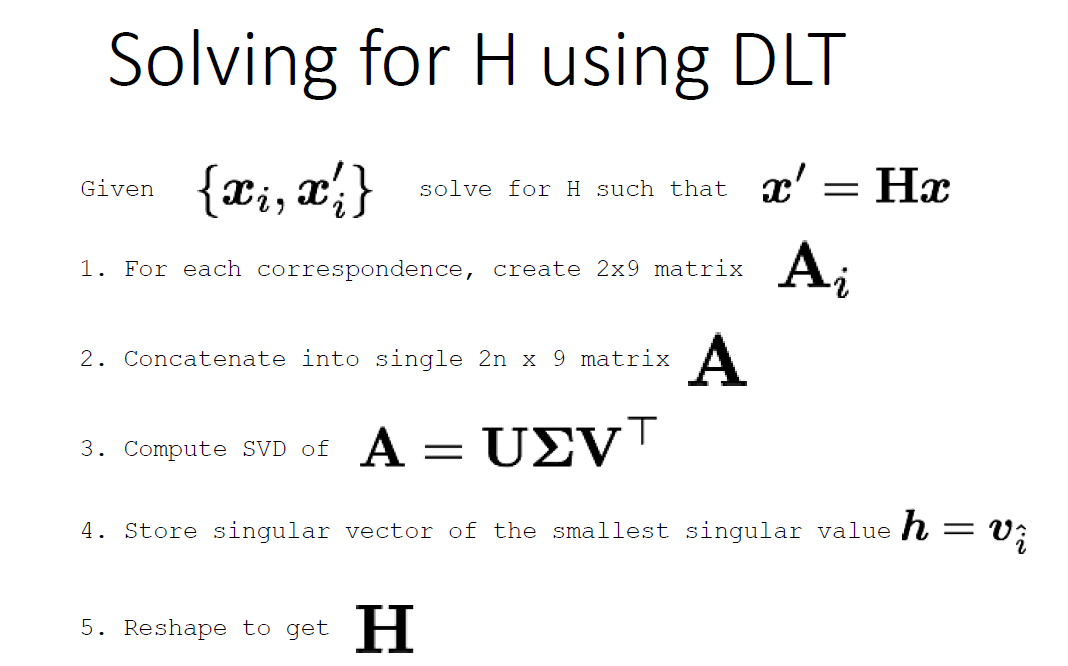

In [24]:
def compute_homography(src_points, dst_points):
    A = []
    for (x, y), (x_prime, y_prime) in zip(src_points, dst_points):
        A.append([-x, -y, -1, 0, 0, 0, x * x_prime, y * x_prime, x_prime])
        A.append([0, 0, 0, -x, -y, -1, x * y_prime, y * y_prime, y_prime])

    A = np.array(A)
    U, S, Vt = np.linalg.svd(A)
    # the last column of V --> corresponds to the eigenvector associated with the smallest singular value (in S)
    H = Vt[-1].reshape(3, 3)
    H = H / H[-1, -1] # we want H 3X3 = 1 (it has 8 DOF)
    return H

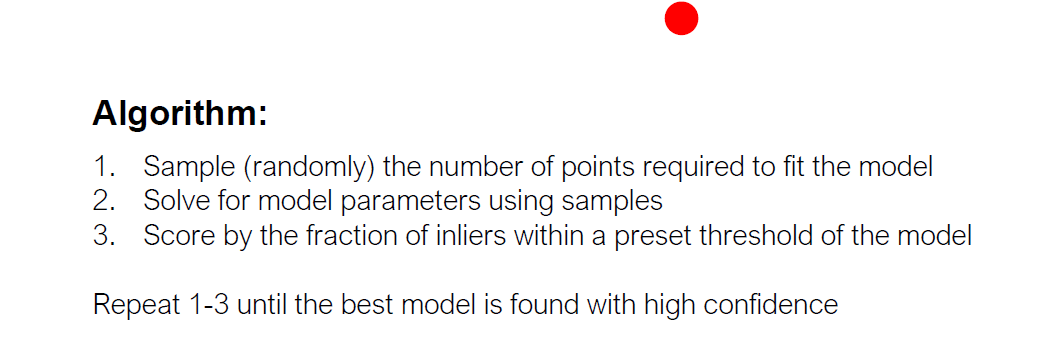

In [ ]:
def ransac_homography(src_points, dst_points, max_iterations=1000, threshold=5.0):
    num_points = src_points.shape[0]
    best_H = None
    max_inliers = 0
    best_inliers = None

    for _ in range(max_iterations):
        # Randomly select 4 points
        idx = np.random.choice(num_points, 4, replace=False)
        selected_src = src_points[idx]
        selected_dst = dst_points[idx]

        # Compute homography for the selected points
        H = compute_homography(selected_src, selected_dst)

        # Transform all source points
        src_homo = np.hstack((src_points, np.ones((num_points, 1))))
        projected_points = (H @ src_homo.T).T

        # Convert to Cartesian coordinates
        projected_points /= projected_points[:, 2][:, np.newaxis]
        projected_points = projected_points[:, :2]

        # Compute the distances
        distances = np.linalg.norm(projected_points - dst_points, axis=1)

        # Determine inliers
        inliers = distances < threshold
        num_inliers = np.sum(inliers)

        # Update best model if more inliers are found
        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_H = H
            best_inliers = inliers

    # Refine the homography using all inliers
    if best_inliers is not None:
        refined_src = src_points[best_inliers]
        refined_dst = dst_points[best_inliers]
        best_H = compute_homography(refined_src, refined_dst)

    return best_H

In [32]:
def map_points(H, src_points):
    src_points_h = np.hstack((src_points, np.ones((src_points.shape[0], 1))))
    # print(src_points_h.shape) 50,3
    dst_points_h = np.dot(H, src_points_h.T).T
    # print(dst_points_h.shape) 50X 3
    dst_points = dst_points_h[:, :2] / dst_points_h[:, 2][:, np.newaxis]  #
    '''
    xy1
    xy1
    xy1
    so simply extract x,y from all of these and then  divide by last column (3l4an lw m4 1😊)
    '''
    # print(dst_points.shape)50X2
    return dst_points


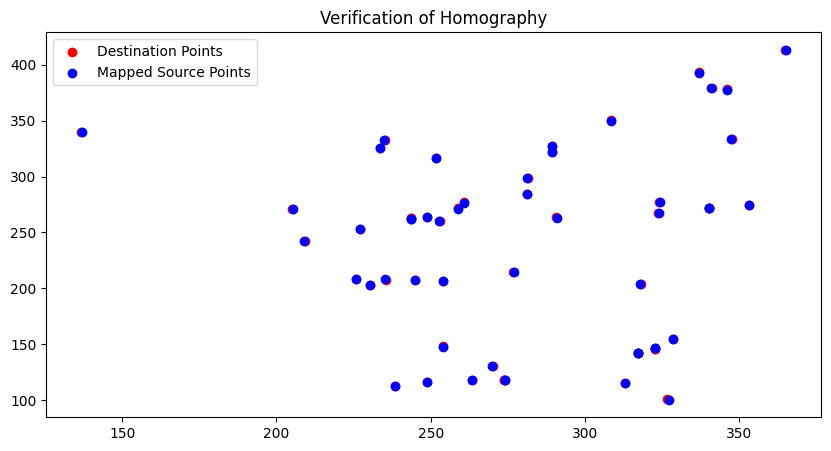

Homography Matrix:
 [[ 7.73175746e-01  2.75722288e-03  1.19569964e+02]
 [-5.11103674e-02  7.78602152e-01  7.74981416e+01]
 [-9.11956120e-05 -7.43420640e-05  1.00000000e+00]]


In [26]:
src_points,dst_points = get_features(video_frame)
H = ransac_homography(src_points, dst_points)
mapped_points = map_points(H, src_points)
plt.figure(figsize=(10, 5))
plt.scatter(dst_points[:, 0], dst_points[:, 1], color='red', label='Destination Points')
plt.scatter(mapped_points[:, 0], mapped_points[:, 1], color='blue', label='Mapped Source Points')
plt.legend()
plt.title('Verification of Homography')
plt.show()
print("Homography Matrix:\n", H)

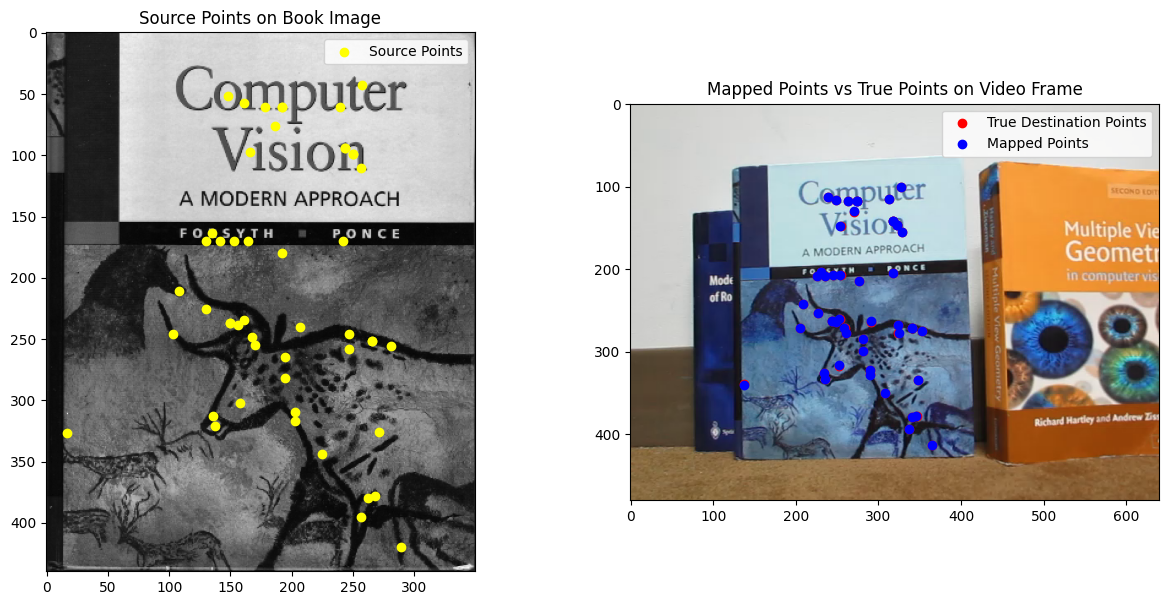

Homography Matrix:
 [[ 7.73175746e-01  2.75722288e-03  1.19569964e+02]
 [-5.11103674e-02  7.78602152e-01  7.74981416e+01]
 [-9.11956120e-05 -7.43420640e-05  1.00000000e+00]]


In [27]:
mapped_points = map_points(H, src_points)
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(book_img, cmap='gray')
plt.scatter(src_points[:, 0], src_points[:, 1], color='yellow', label='Source Points')
plt.title('Source Points on Book Image')
plt.legend()
plt.subplot(1, 2, 2)
plt.imshow(video_frame, cmap='gray')
plt.scatter(dst_points[:, 0], dst_points[:, 1], color='red', label='True Destination Points')
plt.scatter(mapped_points[:, 0], mapped_points[:, 1], color='blue', marker='o', label='Mapped Points')
plt.title('Mapped Points vs True Points on Video Frame')
plt.legend()
plt.show()
print("Homography Matrix:\n", H)

In [37]:
def get_corners(H , video_frame  ,  book_img =  book_img ):
  book_height, book_width = book_img.shape[:2]
  book_corners = np.array([
      [0, 0],
      [book_width - 1, 0],
      [book_width - 1, book_height - 1],
      [0, book_height - 1]
  ], dtype=np.float32)

  mapped_corners = map_points(H, book_corners)
  return mapped_corners


In [38]:
mapped_corners = get_corners(H , video_frame )

---

---

Total frames in video: 511
Successfully read frame 100


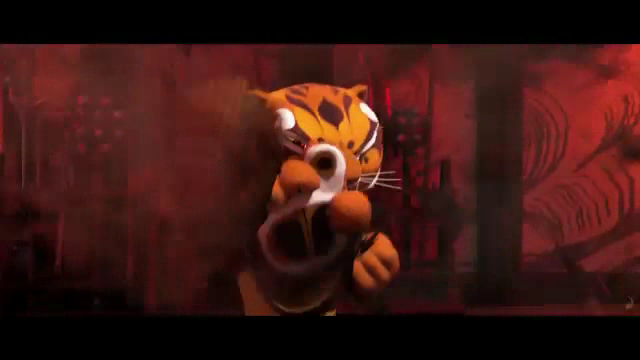

Frame 100 saved as frame_368.jpg


In [45]:
video_path = '/content/drive/MyDrive/assignment_2_materials/ar_source.mov'
video = cv2.VideoCapture(video_path)
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Total frames in video: {total_frames}")
frame_number = 100
if frame_number < total_frames:
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = video.read()
    print(f"Successfully read frame {frame_number}")
    cv2_imshow(frame)

    output_image_path = 'frame_368.jpg'
    cv2.imwrite(output_image_path, frame)
    print(f"Frame {frame_number} saved as {output_image_path}")

video.release()

---

---

#We want to remove the zero rows at the top and bottom#

In [46]:
def  remove_zero_rows(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    non_zero_rows = np.where(gray_image > 20)[0]
    # print(len(non_zero_rows))
    if len(non_zero_rows) < 100:
        return image
    top_row = non_zero_rows[0]
    bottom_row = non_zero_rows[-1]
    cropped_image = image[top_row:bottom_row + 1, :]
    return cropped_image

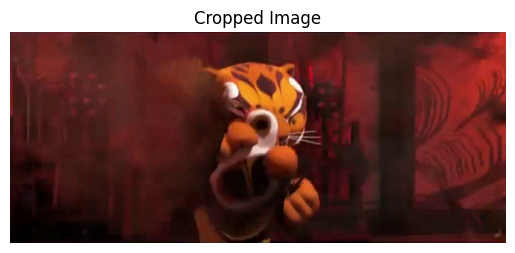

True

In [47]:
image = cv2.imread('/content/frame_368.jpg')
cropped_image = remove_zero_rows(image)
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.title('Cropped Image')
plt.axis('off')
plt.show()
cv2.imwrite('cropped_image.png', cropped_image)

---

---

In [48]:
def resize_and_crop(image, target_width, target_height):
    original_height, original_width = image.shape[:2]
    # Calculate scaling factors
    scale_width = target_width / original_width
    scale_height = target_height / original_height
    # Use the larger scaling factor to ensure the image covers the target dimensions
    scale = max(scale_width, scale_height)
    # Resize the image
    resized_width = int(original_width * scale)
    resized_height = int(original_height * scale)
    resized_image = cv2.resize(image, (resized_width, resized_height))
    # Calculate cropping coordinates
    crop_x = (resized_width - target_width) // 2
    crop_y = (resized_height - target_height) // 2

    # Ensure cropping indices are within bounds
    crop_x = max(0, crop_x)
    crop_y = max(0, crop_y)

    # Crop the image
    cropped_image = resized_image[crop_y:crop_y + target_height, crop_x  :crop_x + target_width ]
    cropped_image = cv2.resize(cropped_image, (target_width, target_height))

    return cropped_image


---

---

In [58]:
def AR_to_Book(H, mapped_corners, panda_image, video_frame):

    '''
    first we have panda frame  , static book , book frame
    we have H that can convert from static book to book frame
    so we resize panda to be like static book
    then we use H and warping to transfer panda resized frame to book frame

    mask --> the place of the panda frame inside the book frame
    1) in book frame make the place of this mask  = zeros to overlay the panda
    2) outputimage --> the output of step 1 + the panda frame
    '''
    target_width = book_img.shape[1]
    target_height = book_img.shape[0]
    resized_panda_image = resize_and_crop(panda_image, round(target_width), round(target_height))
    height, width = video_frame.shape[:2]
    warped_image = cv2.warpPerspective(resized_panda_image, H, (width, height))
    warped_image_resized = cv2.resize(warped_image, (video_frame.shape[1], video_frame.shape[0]))
    mask = cv2.warpPerspective(np.ones_like(resized_panda_image[:, :, 0], dtype=np.uint8), H, (width, height))
    mask_resized = cv2.resize(mask, (video_frame.shape[1], video_frame.shape[0]))
    mask_3d = np.dstack([mask_resized] * 3)
    video_frame[mask_3d > 0] = 0
    output_image = video_frame.copy()
    output_image[mask_3d > 0] = warped_image_resized[mask_3d > 0]
    return output_image


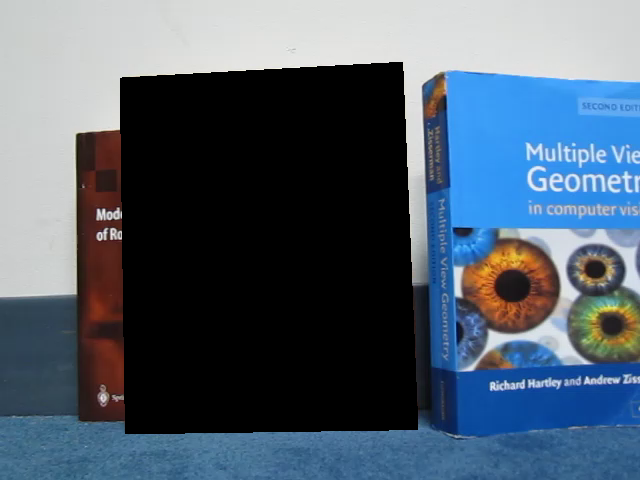

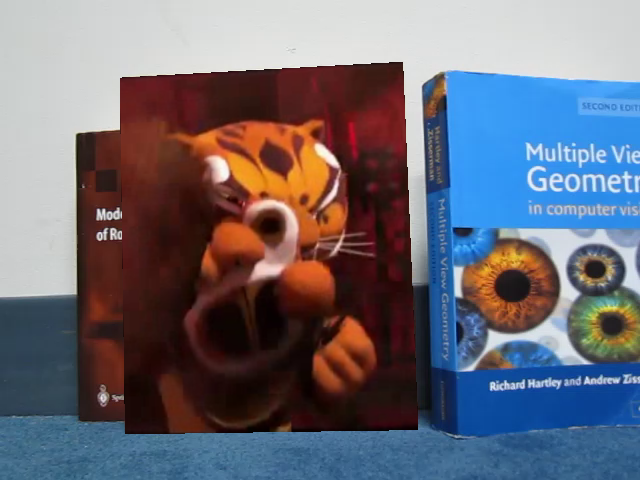

In [59]:
output_image = AR_to_Book (H , mapped_corners ,cropped_image , video_frame )
cv2_imshow(output_image)

---

----

#Make Video#

In [ ]:

book_video = cv2.VideoCapture('/content/drive/MyDrive/assignment_2_materials/book.mov')
ar_video = cv2.VideoCapture('/content/drive/MyDrive/assignment_2_materials/ar_source.mov')

# Define the codec and initialize VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('ar_output.avi', fourcc, int(book_video.get(cv2.CAP_PROP_FPS)),
                      (int(book_video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(book_video.get(cv2.CAP_PROP_FRAME_HEIGHT))))
output_frames = []
while True:
    ret_book, book_frame = book_video.read()
    # cv2_imshow(book_frame)
    ret_ar, ar_frame = ar_video.read()

    if not ret_book or not ret_ar:
        break

    # sort el ktab el sabt wel frame el 7aly -->
    # def get_features(  frame , book_img = book_img ) :
    src_points , dst_points = get_features(book_frame)
    H =  ransac_homography(src_points, dst_points)
    corner_points = get_corners(H, book_frame)

    # plot_corners (H , corner_points , dst_points) # 3l4an n4oof el corners bs


    # preprocess el AR frame el awl  -->  1) remove zero rows  2) resize and crop w kda fol
    ar_frame  = remove_zero_rows(ar_frame)

    # def AR_to_Book (H , corner_points , image_to_warp , video_frame_book ) :
    output_frame = AR_to_Book (H , corner_points ,ar_frame , book_frame )
    # Kda preprocessing el AR frame tmaaammmmmm

    # lets stack these frames together
    output_frames.append(output_frame)
    out.write(output_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
book_video.release()
ar_video.release()
out.release()


----

----